# CISC 351/372 Advanced Data Analytics Group Project

## Group 8: Political Sentiment Analysis In Liberal and Conservative Reddit Communities

### RQ2: How does political sentiment differ between liberal and conservative Reddit communities?

This notebook contains the code to answer the second research question.

## Imports

In [ ]:
%pip install nrclex
%pip install nltk NRCLex tqdm


In [1]:
import json
import pandas as pd

from tqdm import tqdm
from nrclex import NRCLex
from joblib import Parallel, delayed

In [1]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krist\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Prepare Dataset

In [2]:
with open("Conservative.json", "r") as file:
    con_data = json.load(file)

with open("Liberal.json", "r") as file:
    lib_data = json.load(file)

# Convert JSON to a DataFrame
con_df = pd.DataFrame(con_data)
lib_df = pd.DataFrame(lib_data)

# Check the structure
print(con_df.head())
print(lib_df.head())

   WordCount                                            article  \
0       1101  Retired US Army General Wesley Clark called fo...   
1       1312  If a place isn't too far gone to start with, t...   
2        550  On Palm Sunday, the Trust Women Wichita aborti...   
3        762  CARACAS, Venezuela (AP) — A leading Venezuelan...   
4        311  It’s been less than a month since Trump – afte...   

  author_flair_text  created_utc               domain  num_comments  score  \
0                     1437509071             wsws.org             3     18   
1                     1620141553  americanthinker.com            18    313   
2                     1586381822       liveaction.org             0      1   
3                     1399316632       news.yahoo.com             0      7   
4                     1473095574         redstate.com            10     17   

                                                 url       url_domain  \
0  http://www.wsws.org/en/articles/2015/07/21/cla...   

In [3]:
# Faster function using joblib
def get_emotions(text):
    try:
        emotions = NRCLex(text)
        return emotions.raw_emotion_scores
    except:
        return {}

# This will use all CPU cores - or you can pass n_jobs=4 or something
def process_with_joblib(articles):
    results = Parallel(n_jobs=-1)(
        delayed(get_emotions)(text) for text in tqdm(articles)
    )
    return results

# Process again, but now faster
con_emotions = process_with_joblib(con_df['article'].tolist())
lib_emotions = process_with_joblib(lib_df['article'].tolist())

# Save back into DataFrames
con_df['emotions'] = con_emotions
lib_df['emotions'] = lib_emotions

print(con_df[['article', 'emotions']].head())
print(lib_df[['article', 'emotions']].head())


100%|██████████| 72488/72488 [06:59<00:00, 172.75it/s]


                                             article  \
0  Retired US Army General Wesley Clark called fo...   
1  If a place isn't too far gone to start with, t...   
2  On Palm Sunday, the Trust Women Wichita aborti...   
3  CARACAS, Venezuela (AP) — A leading Venezuelan...   
4  It’s been less than a month since Trump – afte...   

                                            emotions  
0  {'fear': 46, 'negative': 49, 'anger': 29, 'sad...  
1  {'anticipation': 26, 'positive': 58, 'joy': 14...  
2  {'disgust': 9, 'fear': 24, 'negative': 25, 'sa...  
3  {'trust': 27, 'anger': 14, 'disgust': 4, 'fear...  
4  {'fear': 5, 'negative': 11, 'sadness': 7, 'ant...  
                                             article  \
0  Front page layout Site theme Sign up or login ...   
1  What the Alt-Right Understands About Winning E...   
2  © 1998-2022 Nexstar Media Inc. All Rights Rese...   
3  Welcome, Christopher Paul Hasson, a Lieutenant...   
4  Text surrounded by asterisks (*) is italicized... 

In [15]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Helper function to combine all emotion scores
def aggregate_emotions(emotion_series):
    total = Counter()
    for emo_dict in emotion_series:
        total.update(emo_dict)
    return total

# Aggregate all emotions for each subreddit
con_total = aggregate_emotions(con_df['emotions'])
lib_total = aggregate_emotions(lib_df['emotions'])

# Convert to DataFrame for comparison
emotion_df = pd.DataFrame({
    "Conservative": pd.Series(con_total),
    "Liberal": pd.Series(lib_total)
}).fillna(0)

# Normalize (optional: to compare proportions)
emotion_df['Conservative %'] = emotion_df['Conservative'] / emotion_df['Conservative'].sum()
emotion_df['Liberal %'] = emotion_df['Liberal'] / emotion_df['Liberal'].sum()

# Show top 5 emotions by count in each subreddit
top_con = emotion_df.sort_values("Conservative", ascending=False).head(5)
top_lib = emotion_df.sort_values("Liberal", ascending=False).head(5)

display(top_con)
display(top_lib)


,Conservative,Liberal,Conservative %,Liberal %
positive,4283760,7889828,0.214211,0.233967
negative,3213129,5098422,0.160674,0.151190
trust,2968177,5085007,0.148425,0.150792
fear,2001194,3028470,0.100070,0.089807
anticipation,1784199,3240020,0.089220,0.096081


,Conservative,Liberal,Conservative %,Liberal %
positive,4283760,7889828,0.214211,0.233967
negative,3213129,5098422,0.160674,0.151190
trust,2968177,5085007,0.148425,0.150792
anticipation,1784199,3240020,0.089220,0.096081
fear,2001194,3028470,0.100070,0.089807


In [19]:
emotion_df.sort_values("Conservative", ascending=False).head(10)


,Conservative,Liberal,Conservative %,Liberal %
positive,4283760,7889828,0.214211,0.233967
negative,3213129,5098422,0.160674,0.151190
trust,2968177,5085007,0.148425,0.150792
fear,2001194,3028470,0.100070,0.089807
anticipation,1784199,3240020,0.089220,0.096081
anger,1533443,2353327,0.076680,0.069786
sadness,1420998,2265117,0.071058,0.067171
joy,1235491,2217659,0.061781,0.065763
disgust,816430,1197214,0.040826,0.035503
surprise,741032,1346837,0.037056,0.039940


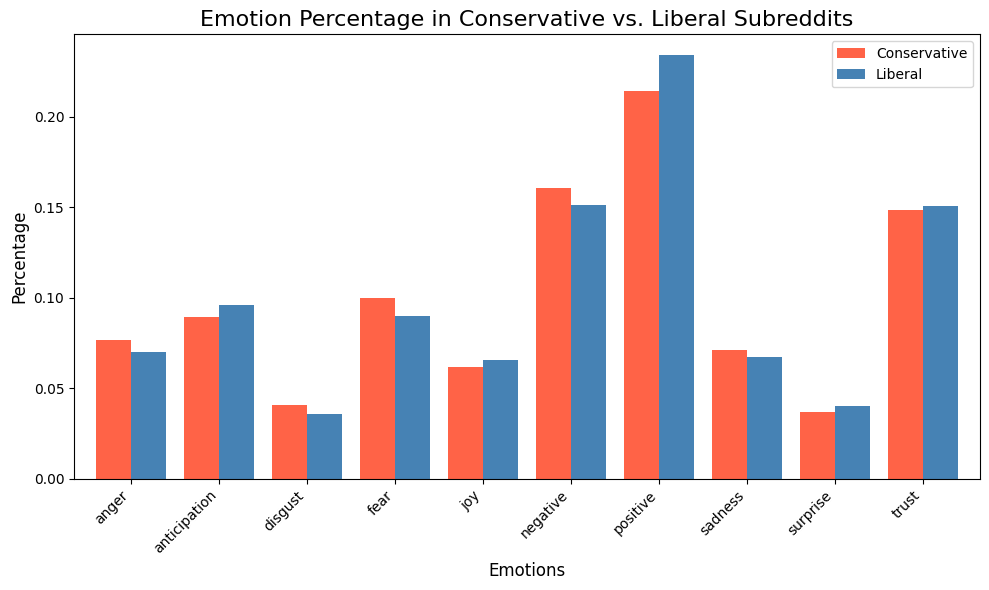

In [21]:
import matplotlib.pyplot as plt

# Set the plot size
plt.figure(figsize=(10, 6))

# Plotting percentages for each subreddit
# For each emotion, plot a bar for Conservative and Liberal, side by side
emotion_df[['Conservative %', 'Liberal %']].plot(kind='bar', width=0.8, color=['#FF6347', '#4682B4'], ax=plt.gca())

# Adding labels and title
plt.title("Emotion Percentage in Conservative vs. Liberal Subreddits", fontsize=16)
plt.xlabel("Emotions", fontsize=12)
plt.ylabel("Percentage", fontsize=12)

# Show legend
plt.legend(["Conservative", "Liberal"], loc="upper right")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()
